In [14]:
'''
in this notebook we convert the data from coco json to activeloop dataset
with the following schema :
WeedBot_schema = {
    'image': Image(shape=(None, None, 3), dtype='uint8', max_shape=(max_width, max_width, 3)), 
    'bbox': Sequence(dtype = BBox()),
    'segmentation' : Sequence(dtype=Segmentation(shape=(None, None, 1), dtype='uint8', max_shape=(max_width, max_width, 1), names=['dauca'])),
}
each image has:
1) a sequence of bounding boxes for each inctance of weed detection
2) a sequence of one-hot binary masks for each instance of weeds detection
'''

"\nin this notebook we convert the data from coco json to activeloop dataset\nwith the following schema :\nWeedBot_schema = {\n    'image': Image(shape=(None, None, 3), dtype='uint8', max_shape=(max_width, max_width, 3)), \n    'bbox': Sequence(dtype = BBox()),\n    'segmentation' : Sequence(dtype=Segmentation(shape=(None, None, 1), dtype='uint8', max_shape=(max_width, max_width, 1), names=['dauca'])),\n}\neach image has:\n1) a sequence of bounding boxes for each inctance of weed detection\n2) a sequence of one-hot binary masks for each instance of weeds detection\n"

In [15]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import json
import pprint
import hub
from hub import Dataset, schema
from hub.schema import Image,ClassLabel,Segmentation,BBox,Tensor,Sequence
from pycocotools.coco import COCO

In [16]:
#Data paths
json_file = 'B2.json'
images_PATH = 'images/'

In [17]:
#load COCO json file
json_loaded = json.load(open(json_file, 'r'))
coco = COCO(json_file)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


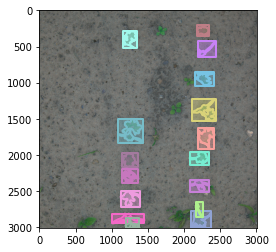

In [23]:
#visualize the data
imageID = 1
annsIds = coco.getAnnIds(imgIds=[imageID])
anns = coco.loadAnns(annsIds)
image = (coco.loadImgs([imageID]))[0]
plt.imshow(cv.imread(images_PATH+image['file_name']))
coco.showAnns(anns,draw_bbox=True)

In [10]:
#get max width and height for images, useful when creating schemas
def get_max_dims(json_loaded):
    heights = []
    widths = []
    max_height = 0
    max_width = 0
    for im in json_loaded['images']:
        height = int(im['height'])
        width = int(im['width'])
        heights.append(height)
        widths.append(width)
        max_height = max(heights)
        max_width = max(widths)
    return max_width,max_height
max_width,max_height = get_max_dims(json_loaded)

In [11]:
WeedBot_schema = {
    'image': Image(shape=(None, None, 3), dtype='uint8', max_shape=(max_width, max_width, 3)), 
    'bbox': Sequence(dtype = BBox()),
    'segmentation' : Sequence(dtype=Segmentation(shape=(None, None, 1), dtype='uint8', max_shape=(max_width, max_width, 1), names=['dauca'])),
}
number_of_examples = len(coco.getImgIds())
print(number_of_examples)

500


In [ ]:
WeedBot_Dataset =Dataset('thomasartin/weedbot-omdena',shape=(number_of_examples,), schema=WeedBot_schema)

In [12]:
imgIDS = coco.getImgIds()
imgs = coco.loadImgs(imgIDS)

In [ ]:
for i in range(len(imgIDS)):
    image_file = images_PATH + imgs[i]['file_name']
    image = cv.imread(image_file)
    WeedBot_Dataset['image',i] = image
    annotationIDS = coco.getAnnIds(imgIDS[i])
    annotations = coco.loadAnns(annotationIDS)
    masks = []
    bboxes = []
    for annotation in annotations:
        masks.append(coco.annToMask(annotation))
        bbox = annotation['bbox']
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[0]+bbox[2]
        y2 = bbox[1]+bbox[3]
        bboxes.append([x1,y1,x2,y2])
    WeedBot_Dataset['segmentation',i] = masks
    WeedBot_Dataset['bbox',i] = bbox

In [ ]:
WeedBot_Dataset.commit()